Problem Statement:

Build a predictive model and find out the sales of each product at a particular store.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Data Exploration

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
train['source']='train'
test['source']='test'
data_all = pd.concat([train, test], ignore_index=True)
print(train.shape, test.shape, data_all.shape)

(8523, 13) (5681, 12) (14204, 13)


In [3]:
data_all.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
count,14204,11765.000000,14204,14204.000000,14204,14204.000000,14204,14204.000000,10188,14204,14204,8523.000000,14204
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN,2
top,FDC41,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN,train
freq,10,NaN,8485,NaN,2013,NaN,1559,NaN,4655,5583,9294,NaN,8523
mean,NaN,12.792854,NaN,0.065953,NaN,141.004977,NaN,1997.830681,NaN,NaN,NaN,2181.288914,NaN
std,NaN,4.652502,NaN,0.051459,NaN,62.086938,NaN,8.371664,NaN,NaN,NaN,1706.499616,NaN
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000,NaN
25%,NaN,8.710000,NaN,0.027036,NaN,94.012000,NaN,1987.000000,NaN,NaN,NaN,834.247400,NaN
50%,NaN,12.600000,NaN,0.054021,NaN,142.247000,NaN,1999.000000,NaN,NaN,NaN,1794.331000,NaN
75%,NaN,16.750000,NaN,0.094037,NaN,185.855600,NaN,2004.000000,NaN,NaN,NaN,3101.296400,NaN


In [4]:
data_all.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,DRA12,11.6,Low Fat,0.041178,Soft Drinks,140.3154,OUT017,2007,NaN,Tier 2,Supermarket Type1,2552.6772,train
1,DRA12,11.6,Low Fat,0.000000,Soft Drinks,141.6154,OUT045,2002,NaN,Tier 2,Supermarket Type1,3829.0158,train
2,DRA12,11.6,Low Fat,0.040912,Soft Drinks,142.3154,OUT013,1987,High,Tier 3,Supermarket Type1,2552.6772,train
3,DRA12,11.6,LF,0.000000,Soft Drinks,141.9154,OUT035,2004,Small,Tier 2,Supermarket Type1,992.7078,train
4,DRA12,11.6,Low Fat,0.041113,Soft Drinks,142.0154,OUT018,2009,Medium,Tier 3,Supermarket Type2,850.8924,train


In [5]:
categorical_columns = [x for x in data_all.dtypes.index if data_all.dtypes[x] =='object']
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier',
                                                                  'source']]

for col in categorical_columns:
    print(data_all[col].value_counts())

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64
Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64


Missing information:
1. Item Weight - unlikely to be of significant value to predicting sales
2. Outlet_Size - 2410 missing values, size of an outlet may limit selection of item types for customers
3. Item_Outlet_sales - target value to be predicted

Missing values will be filled in later!

Observations:
1. Outlet_Establishment_Year vary from 1985 to 2009. Easier to convert to age.
2. 10 different outlets (10 unique outlet_identifier) in the dataset. Outlet_size could be filled by finding out the respective sizes of each outlet
3. 1559 unique items sold by the stores 
4. 16 item types
5. Item visibility min = 0, max = 0.32. Visibilty 0 means item can't be spotted? Does that make sense?
6. Item_Fat_Content categorized with different key words but actually the same

<h2>DATA CLEANING</h2>

Pre-processing before plotting and determing relationship between attributes of an item and its sale

1. Item Weight
<p>Find matching Item Identifier and fill with corresponding item weight</p>

In [6]:
item_avg_weight = pd.pivot_table(data_all, values='Item_Weight',index='Item_Identifier')

id_noweight = data_all[data_all['Item_Weight'].isnull()]
miss_bool = data_all['Item_Weight'].isnull()
# item_avg_weight.loc[id_noweight['Item_Identifier']]

data_all.loc[miss_bool,'Item_Weight'] = data_all.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])

2. Outlet size
<p>Using outlet type, estimate size of outlet</p>

In [7]:
from scipy.stats import mode

outlet_size_mode = pd.pivot_table(data_all,values='Outlet_Size',columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]))

miss_bool = data_all['Outlet_Size'].isnull()

data_all.loc[miss_bool,'Outlet_Size'] = data_all.loc[miss_bool,'Outlet_Type'].apply(lambda x:outlet_size_mode[x])

In [8]:
data_all.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

3. Item Visibility
<p>As seen in the scatterplot, several data points with 0 visibility, which doesn't make sense. Taking them as missing values, to replace them with corresponding visibility for the item</p>

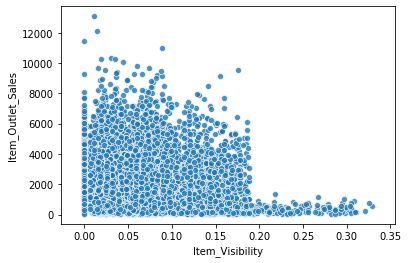

In [9]:
sns.scatterplot(data=data_all, x='Item_Visibility',y='Item_Outlet_Sales', alpha=0.8)

In [10]:
visibility_avg = data_all.pivot_table(values='Item_Visibility',index='Item_Identifier')

miss_bool = data_all['Item_Visibility']==0

data_all.loc[miss_bool,'Item_Visibility'] = data_all.loc[miss_bool,'Item_Identifier'].apply(lambda x:visibility_avg.loc[x])

In [11]:
visibility_avg.head()

,Item_Visibility
Item_Identifier,
DRA12,0.034938
DRA24,0.045646
DRA59,0.133384
DRB01,0.079736
DRB13,0.006799


In [12]:
data_all['Item_Visibility_MeanRatio']=data_all.apply(lambda x:x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']], axis=1)
data_all['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64

4. Item re-categorization

In [13]:
# taking first 2 letters of Items identifier to determine type of item
data_all['Item_Type_Combined']=data_all['Item_Identifier'].apply(lambda x:x[0:2])

data_all['Item_Type_Combined'] = data_all['Item_Type_Combined'].map({'FD':'Food',
                                                                    'NC':'Non-Consumable',
                                                                    'DR':'Drinks'})
data_all['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

5. Examine years of operation

In [14]:
data_all['Outlet_Years'] = 2020 - data_all['Outlet_Establishment_Year']
data_all['Outlet_Years'].describe()

count    14204.000000
mean        22.169319
std          8.371664
min         11.000000
25%         16.000000
50%         21.000000
75%         33.000000
max         35.000000
Name: Outlet_Years, dtype: float64

6. Conversion of Item_Fat_Content

In [15]:
def fat_recat(text):
    if (text == 'LF') | (text=='low fat') | (text=='Low Fat'):
        return 'Low Fat'
    if (text == 'reg') | (text =='Regular'):
        return 'Regular'

data_all['Item_Fat_Content'] = data_all['Item_Fat_Content'].apply(fat_recat)

In [16]:
data_all.loc[data_all['Item_Type_Combined']=='Non-Consumable','Item_Fat_Content']="Non-Edible"
data_all['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

<h2>Encoding variables<h2>

In [17]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

In [18]:
le = LabelEncoder()

data_all['Outlet'] = le.fit_transform(data_all['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
for i in var_mod:
    data_all[i]=le.fit_transform(data_all[i])
#     print(i)
    
data = pd.get_dummies(data_all,columns=['Item_Fat_Content',
                                        'Outlet_Location_Type',
                                        'Outlet_Size',
                                        'Item_Type_Combined',
                                        'Outlet_Type',
                                        'Outlet'])

In [19]:
data = data.drop(['Outlet_Establishment_Year','Item_Type','Outlet_Identifier', 'Item_MRP','Item_Weight'], axis=1)
train = data[data['source']=='train']
test = data[data['source']=='test']
train1 = train.drop(['source'], axis=1)
# test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)

<h2>Model Development</h2>

Linear Regression

In [20]:
x = train1.drop(['Item_Identifier','Item_Outlet_Sales'], axis=1)
y = train1['Item_Outlet_Sales']

In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state=0)

In [31]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
r2_lr = r2_score(y_test,y_pred)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("r2: ", r2_lr)
print("RMSE: ", rmse_lr)
print(lr.intercept_)

r2:  0.23751915495125187
RMSE:  1480.7496115254014
1672.9753621941318


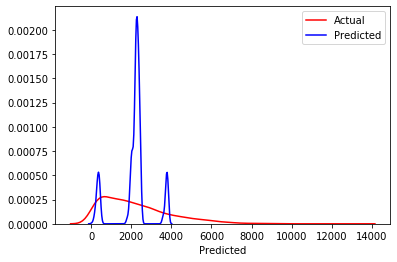

In [27]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.distplot(df1['Actual'], hist=False,color='red',label='Actual')
sns.distplot(df1['Predicted'], hist=False, color='blue',label='Predicted')

Polynomial Regression

Random Forest

In [33]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred2 = rf.predict(x_test)
r2_rf= r2_score(y_test, y_pred2)
mse_rf = mean_squared_error(y_test,y_pred2)
rmse_rf = np.sqrt(mse_rf)

print("r2: ", r2_rf)
print("RMSE: ", rmse_rf)

C:\Users\tanmf\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r2:  0.14320373422983923
RMSE:  1569.6612641377064


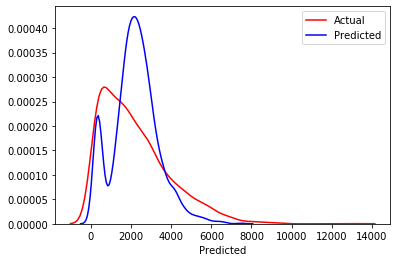

In [34]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2})
sns.distplot(df2['Actual'], hist=False,color='red',label='Actual')
sns.distplot(df2['Predicted'], hist=False, color='blue',label='Predicted')

In [ ]:
y_pred2

In [36]:
F_scores = {'Model':['LR','RF'],
           'RMSE':[rmse_lr, rmse_rf],
           'R2': [r2_lr, r2_rf]}
df_scores = pd.DataFrame(F_scores, columns = ['Model','RMSE','R2'])
df_scores

,Model,RMSE,R2
0,LR,1480.749612,0.237519
1,RF,1569.661264,0.143204
